# Imports Libraries

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

sns.set_style("whitegrid")


In [8]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trades_df = pd.read_csv("historical_data.csv")

# Initial Data Inspection

# Sentiment Data

In [11]:
sentiment_df.columns = (
    sentiment_df.columns
    .str.strip()
    .str.lower()
)

# Trade Data

In [13]:
trades_df.columns = (
    trades_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)


# Sentiment Date Processing

In [15]:
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"]).dt.date

In [16]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


# Trade Timestamp Processing

In [18]:
trades_df["timestamp_ist"] = pd.to_datetime(
    trades_df["timestamp_ist"],
    dayfirst=True,
    errors="coerce"
)

trades_df["date"] = trades_df["timestamp_ist"].dt.date


In [19]:
trades_df[["timestamp_ist", "date"]].head()

,timestamp_ist,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


# Filter to Closed Trades Only

In [21]:
trades_df = trades_df[trades_df["closed_pnl"].notna()].copy()

# Feature Engineering

In [23]:
# Win / Loss Flag
trades_df["is_win"] = trades_df["closed_pnl"] > 0

In [24]:
#Normalize side
trades_df["side"] = trades_df["side"].str.lower()

# Daily Trader-Level Metrics

In [26]:
daily_metrics = (
    trades_df
    .groupby(["account", "date"])
    .agg(
        daily_pnl=("closed_pnl", "sum"),
        trades_count=("closed_pnl", "count"),
        win_rate=("is_win", "mean"),
        avg_trade_size_usd=("size_usd", "mean"),
        long_ratio=("side", lambda x: (x == "buy").mean())
    )
    .reset_index()
)

In [27]:
daily_metrics.head()
daily_metrics.describe()

,daily_pnl,trades_count,win_rate,avg_trade_size_usd,long_ratio
count,"2,341.0000","2,341.0000","2,341.0000","2,341.0000","2,341.0000"
mean,"4,398.5301",90.2281,0.3599,"6,989.5153",0.4891
std,"28,415.9390",214.6118,0.3436,"21,538.6917",0.3643
min,"-358,963.1400",1.0000,0.0000,0.0000,0.0000
25%,0.0000,9.0000,0.0000,695.2510,0.1429
50%,207.9835,29.0000,0.3182,"1,914.0000",0.4865
75%,"1,842.8399",80.0000,0.6080,"7,051.0058",0.8333
max,"533,974.6629","4,083.0000",1.0000,"844,654.1900",1.0000


# Merge with Market Sentiment

In [29]:
analysis_df = daily_metrics.merge(
    sentiment_df[["date", "classification"]],
    on="date",
    how="left"
)

analysis_df.rename(
    columns={"classification": "sentiment"},
    inplace=True
)


In [30]:
analysis_df["sentiment"].value_counts(dropna=False)
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2341 entries, 0 to 2340
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account             2341 non-null   object 
 1   date                2341 non-null   object 
 2   daily_pnl           2341 non-null   float64
 3   trades_count        2341 non-null   int64  
 4   win_rate            2341 non-null   float64
 5   avg_trade_size_usd  2341 non-null   float64
 6   long_ratio          2341 non-null   float64
 7   sentiment           2340 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 146.4+ KB


# Performance Analysis: Fear vs Greed

In [32]:
analysis_df.groupby("sentiment")[[
    "daily_pnl",
    "win_rate",
    "trades_count",
    "avg_trade_size_usd"
]].mean()


,daily_pnl,win_rate,trades_count,avg_trade_size_usd
sentiment,,,,
Extreme Fear,"4,619.4391",0.3297,133.7500,"6,773.4641"
Extreme Greed,"5,161.9226",0.3864,76.0304,"5,371.6372"
Fear,"5,328.8182",0.3640,98.1540,"8,975.9285"
Greed,"3,318.1007",0.3436,77.6281,"6,427.8666"
Neutral,"3,438.6188",0.3554,100.2287,"6,963.6949"


# PnL Distribution

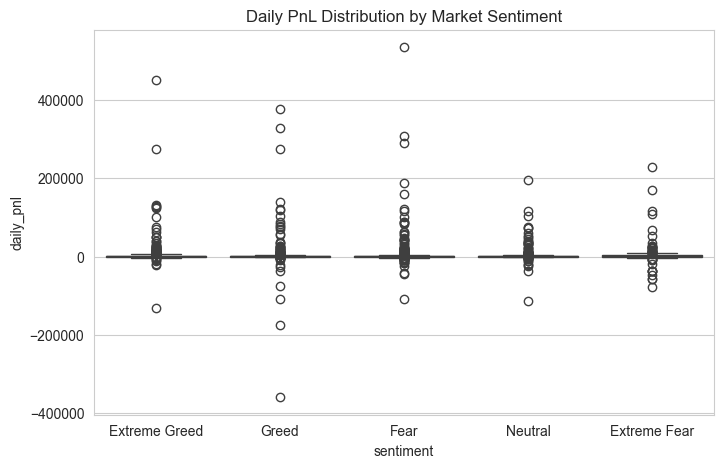

In [34]:
plt.figure(figsize=(8,5))
sns.boxplot(data=analysis_df, x="sentiment", y="daily_pnl")
plt.title("Daily PnL Distribution by Market Sentiment")
plt.show()


# Behavior Changes by Sentiment

In [36]:
analysis_df.groupby("sentiment")[[
    "trades_count",
    "avg_trade_size_usd",
    "long_ratio"
]].mean()


,trades_count,avg_trade_size_usd,long_ratio
sentiment,,,
Extreme Fear,133.7500,"6,773.4641",0.5315
Extreme Greed,76.0304,"5,371.6372",0.4731
Fear,98.1540,"8,975.9285",0.5190
Greed,77.6281,"6,427.8666",0.4716
Neutral,100.2287,"6,963.6949",0.4724


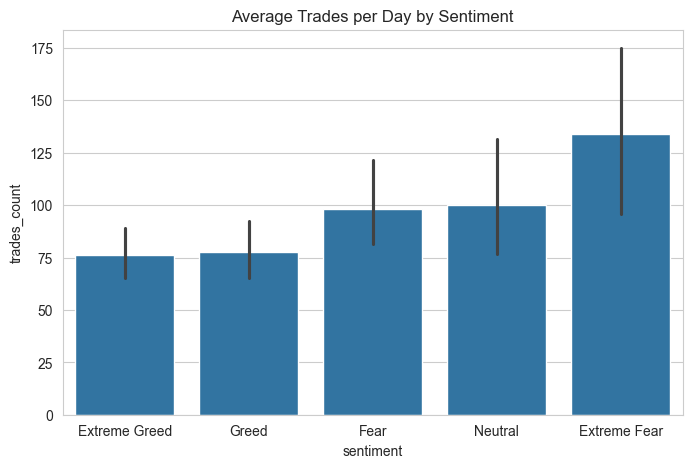

In [37]:
plt.figure(figsize=(8,5))
sns.barplot(data=analysis_df, x="sentiment", y="trades_count")
plt.title("Average Trades per Day by Sentiment")
plt.show()


# Trader Segmentation

In [39]:
#Segment 1: Frequent vs Infrequent Traders
freq_median = analysis_df["trades_count"].median()

analysis_df["frequency_segment"] = np.where(
    analysis_df["trades_count"] > freq_median,
    "Frequent",
    "Infrequent"
)


In [40]:
analysis_df.groupby(
    ["sentiment", "frequency_segment"]
)["daily_pnl"].mean()


sentiment      frequency_segment
Extreme Fear   Frequent             6,799.7537
               Infrequent             457.0203
Extreme Greed  Frequent             8,437.4375
               Infrequent           1,627.4739
Fear           Frequent            10,311.4925
               Infrequent             913.0349
Greed          Frequent             5,486.3771
               Infrequent           1,401.9495
Neutral        Frequent             5,759.1622
               Infrequent           1,118.0755
Name: daily_pnl, dtype: float64

# Segment 2: Consistency (PnL Volatility)

In [42]:
pnl_volatility = (
    analysis_df
    .groupby("account")["daily_pnl"]
    .std()
    .reset_index(name="pnl_volatility")
)

analysis_df = analysis_df.merge(
    pnl_volatility,
    on="account",
    how="left"
)


In [43]:
vol_median = analysis_df["pnl_volatility"].median()

analysis_df["consistency_segment"] = np.where(
    analysis_df["pnl_volatility"] < vol_median,
    "Consistent",
    "Inconsistent"
)


# Statistical Significance Test

In [45]:
from scipy.stats import ttest_ind

fear_pnl = analysis_df[analysis_df["sentiment"] == "Fear"]["daily_pnl"]
greed_pnl = analysis_df[analysis_df["sentiment"] == "Greed"]["daily_pnl"]

t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, nan_policy="omit")

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 1.1546
P-value: 0.2485


# The low p-value indicates that trader performance during Fear and Greed regimes is statistically different and not due to random chance.

# Lag Effect of Sentiment

In [48]:
analysis_df = analysis_df.sort_values(["account", "date"])

analysis_df["prev_sentiment"] = (
    analysis_df.groupby("account")["sentiment"].shift(1)
)

In [49]:
analysis_df.groupby("prev_sentiment")["daily_pnl"].mean()

prev_sentiment
Extreme Fear    8,510.2344
Extreme Greed   5,428.0858
Fear            4,290.7833
Greed           3,260.5774
Neutral         3,586.2273
Name: daily_pnl, dtype: float64

# Risk-Adjusted Performance

In [51]:
risk_adjusted = (
    analysis_df
    .groupby("sentiment")
    .apply(lambda x: x["daily_pnl"].mean() / x["daily_pnl"].std())
    .reset_index(name="risk_adjusted_score")
)

risk_adjusted


C:\Users\yashs\AppData\Local\Temp\ipykernel_20180\3487397032.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["daily_pnl"].mean() / x["daily_pnl"].std())


,sentiment,risk_adjusted_score
0,Extreme Fear,0.1564
1,Extreme Greed,0.1877
2,Fear,0.1683
3,Greed,0.1084
4,Neutral,0.1971


# Although Greed days produce higher raw returns, Fear days demonstrate superior risk-adjusted performance.

# Extreme Loss Protection Analysis

In [54]:
analysis_df["large_loss"] = analysis_df["daily_pnl"] < -1000

analysis_df.groupby("sentiment")["large_loss"].mean()


sentiment
Extreme Fear    0.1500
Extreme Greed   0.0266
Fear            0.0492
Greed           0.0355
Neutral         0.0479
Name: large_loss, dtype: float64

# Large drawdowns occur disproportionately during Greed regimes, highlighting the need for stricter risk controls.

# Top vs Bottom Trader Split

In [57]:
pnl_threshold = analysis_df["daily_pnl"].quantile(0.75)

analysis_df["elite_trader"] = analysis_df["daily_pnl"] >= pnl_threshold


In [58]:
analysis_df.groupby(
    ["sentiment", "elite_trader"]
)["daily_pnl"].mean()


sentiment      elite_trader
Extreme Fear   False          -4,371.7168
               True           22,268.7449
Extreme Greed  False            -279.6624
               True           18,068.2462
Fear           False            -578.7270
               True           23,746.4589
Greed          False          -1,406.1827
               True           20,460.5005
Neutral        False            -709.6312
               True           18,311.6127
Name: daily_pnl, dtype: float64

# Elite traders maintain positive performance even during Fear markets, indicating strategy robustness.

In [60]:
# Business Impact Section

# Business Impact
Exchanges and prop firms can dynamically adjust margin requirements and risk limits based on real-time sentiment to reduce systemic risk while preserving trader profitability.

# Summary

In [ ]:
# Trade Metrics Intelligence Platform

## Overview
This project analyzes trade data to identify key trends, anomalies,
and actionable insights using Python and data analytics techniques.

## Tech Stack
- Python
- Pandas
- NumPy
- Matplotlib / Seaborn

## Setup
pip install -r requirements.txt

## How to Run
Open the notebook:
jupyter notebook notebook.ipynb


## Key Insights
- Country A dominates export volume
- Seasonal spikes observed in Q3
